### Nagrinėkime realesnį pavyzdį:
### Atsisiųskime vaizdų

In [ ]:
# pip install openimages

In [2]:
import os
from openimages.download import download_dataset

In [3]:
data_dir = "data"
## Tarkime turime nedaug duomenų
number_for_samples = 100
classes = ["Apple", "Motorcycle"]

In [4]:
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [4]:
print("Downloading is starting...")
download_dataset(data_dir, classes, limit=number_for_samples)

2024-02-17  12:27:37 INFO Downloading 100 train images for class 'apple'
100%|██████████| 100/100 [00:06<00:00, 15.48it/s]
2024-02-17  12:27:44 INFO Downloading 100 train images for class 'motorcycle'
100%|██████████| 100/100 [00:07<00:00, 13.83it/s]


{'apple': {'images_dir': 'data\\apple\\images'},
 'motorcycle': {'images_dir': 'data\\motorcycle\\images'}}

In [1]:
import torch
import torchvision
from torch.autograd import Variable

In [5]:
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np
from skimage import io
from skimage.transform import resize
from skimage.color import gray2rgb
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
# tipinės transformacijos vaizdams
# scaler = transforms.Scale((224, 224)) -> scaler = transforms.Resize((224, 224))

In [7]:
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

In [8]:
def read_img(file_name):
    img = io.imread(file_name)
    if img.ndim == 2:
      img = gray2rgb(img)
    img = [resize(img, (224, 224))]
    img = torch.tensor(img)
    img = img.permute(0, 3, 1, 2)
    return img.float()

In [ ]:
## Apsibrėžiame vaizdų transformacijas -- augmentacijas
#     torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),

In [10]:
transform = transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20),
    transforms.ToTensor()
])

In [11]:
class CustomDataset(Dataset):
    def __init__(self, images_dir):
        self.images_dir = images_dir
        self.transforms = transforms

        # change number 1: change paths
        self.class1_files = glob.glob(self.images_dir + "/{}/images/*.jpg".format(classes[0].lower()))
        self.class2_files = glob.glob(self.images_dir + "/{}/images/*.jpg".format(classes[1].lower()))
        self.class1 = len(self.class1_files)
        self.class2 = len(self.class2_files)


        self.files = self.class1_files + self.class2_files

        # change number 2: if there was issues with number of samples set labels
        self.labels = np.zeros(len(self.files))
        self.labels[self.class1:] = 1

        # shuffle data
        self.order =  [x for x in np.random.permutation(len(self.labels))]
        self.files = [self.files[x] for x in self.order]
        self.labels = [self.labels[x] for x in self.order]


         
    def __len__(self):
        return (len(self.labels))
    
    def __getitem__(self, i):
        files = self.files[i]

        im = read_img(files)[0]

        img = np.array(im.numpy())
        img = torch.tensor(img)
            
        y = self.labels[i]
        return (img, y)

# change number 1: change paths
dataset = CustomDataset("./data")


In [12]:
len(dataset)

200

In [14]:
for i in [0, 10, 22]:
    sample = dataset[i]
    print(sample[0].shape, sample[1])

torch.Size([3, 224, 224]) 0.0
torch.Size([3, 224, 224]) 1.0
torch.Size([3, 224, 224]) 0.0


In [15]:
train_dataset = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)

In [16]:
images, labels = next(iter(train_dataset))
images.shape


torch.Size([10, 3, 224, 224])

torch.Size([3, 224, 224])


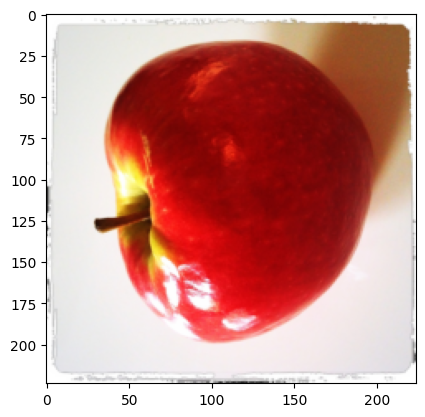

In [17]:
print(images[0].shape)
im = images[0].permute(2, 1, 0)
plt.imshow(im)